In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.getcwd()

'/content'

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [4]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [5]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [6]:
def load_data():
    data = pd.read_csv('/content/drive/MyDrive/RegularSession/0804_supervised_learning/data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [7]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [8]:
len(train_x)

88

In [9]:
# 데이터 셋을 둘러보는 코드 작성하시고, 왜 좋은지 한번 둘러보세요!
train_x.head(5)

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0


In [10]:
train_x.isnull().sum()

Temp             0
Wind             0
Moisture         0
Precipitation    0
Sun              0
dtype: int64

In [11]:
train_x['y'] = train_y

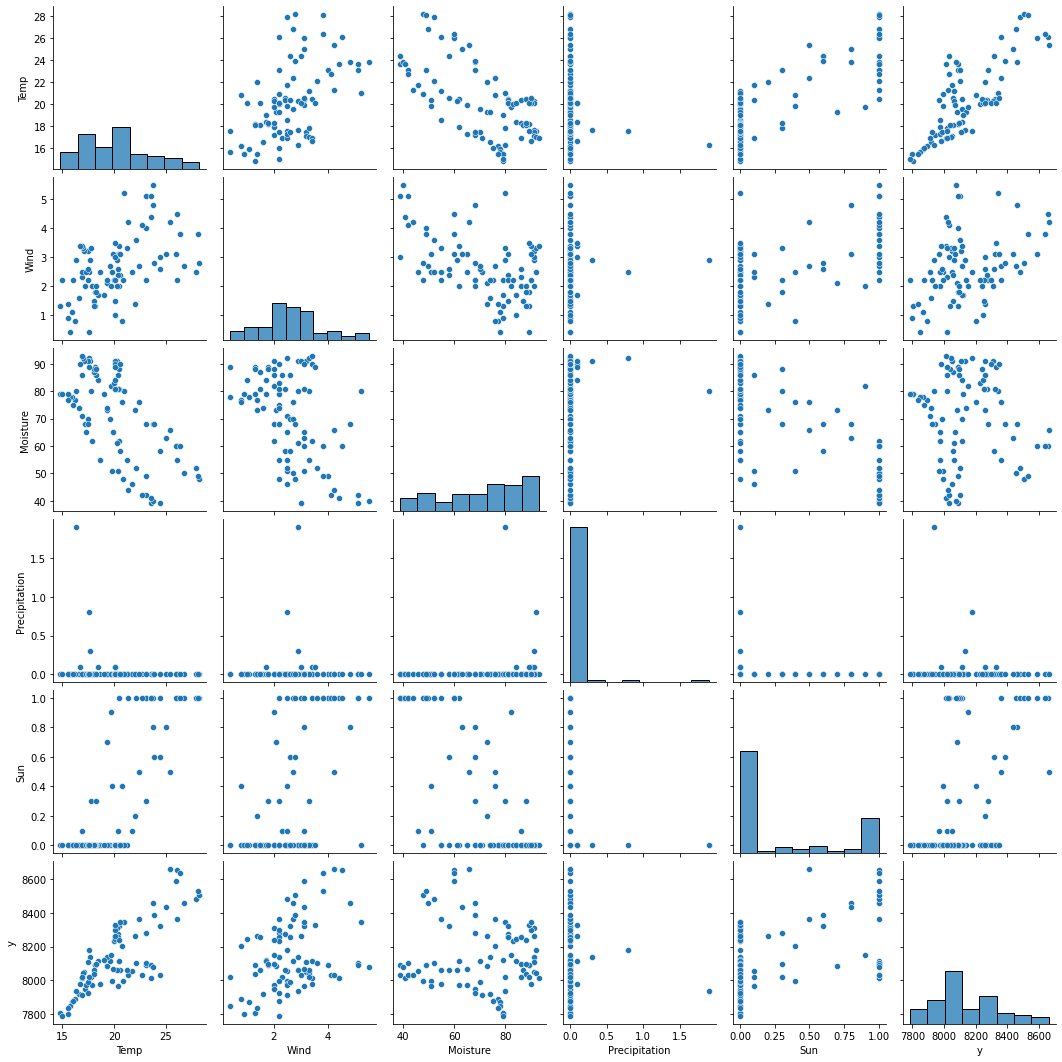

In [12]:
import seaborn as sns
sns.pairplot(train_x)

In [13]:
train_x.corr()

,Temp,Wind,Moisture,Precipitation,Sun,y
Temp,1.000000,0.510935,-0.628642,-0.173210,0.783829,0.803301
Wind,0.510935,1.000000,-0.478825,0.028617,0.544720,0.349288
Moisture,-0.628642,-0.478825,1.000000,0.152529,-0.699047,-0.095042
Precipitation,-0.173210,0.028617,0.152529,1.000000,-0.123846,-0.090389
Sun,0.783829,0.544720,-0.699047,-0.123846,1.000000,0.458348
y,0.803301,0.349288,-0.095042,-0.090389,0.458348,1.000000


In [14]:
del train_x['y']

In [15]:
train_x = train_x[['Temp','Wind','Moisture']]

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : Temp, Wind, Mositure  
Sun의 경우 분포가 0과 1에 몰려있음에도 불구하고 Temp과의 상관계수가 높은 편이기에 Temp으로도 Sun의 특징이 충분하게 설명 가능할 것 같다.  
Precipitation의 경우도 moisture이 강수량의 특징을 설명 가능할 거 같아 제거하였다.  

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [16]:
# 사용할 패키지를 import!
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
scaler = scaler.fit(train_x)
train_x = scaler.transform(train_x)

In [18]:
train_x.shape

(88, 3)

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [19]:
# 사용할 패키지를 import!
from sklearn.linear_model import Ridge

In [20]:
# 선형회귀 모델 생성 후 fitting 시킵니다.
model = Ridge(random_state=123).fit(train_x, train_y)

In [21]:
'''
ridge_beta = model.coef_[0]
ridge_intercept = model.intercept_[0]
print(f"Beta :{ridge_beta}")
print(f"Intercept : {ridge_intercept: .4f}")
'''

'\nridge_beta = model.coef_[0]\nridge_intercept = model.intercept_[0]\nprint(f"Beta :{ridge_beta}")\nprint(f"Intercept : {ridge_intercept: .4f}")\n'

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [22]:
esti_y = model.predict(train_x)

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [23]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [24]:
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 3052.82759


In [25]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

In [26]:
# visualization 하실 분은 진행해주세요!
# visualize(model, train_x, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [27]:
test_x = test_x[['Temp','Wind','Moisture']]

In [28]:
# transform을 하시는 분들은 실행해주세요
test_x = scaler.transform(test_x)

In [29]:
# y1_hat에 predict값 할당
pred_y = model.predict(test_x)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [30]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [31]:
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 100981.65137


In [32]:
score(train_mse,test_mse)

 33.0781


# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

고생하셨습니다!

Temp만 가지고 model 만들기

In [33]:
train_x, train_y, test_x, test_y = load_data()

train_x = train_x[['Temp']]
test_x = test_x[['Temp']]

# 사용할 패키지를 import!
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train_x)
train_x = scaler.transform(train_x)

In [34]:
train_x.shape


(88, 1)

In [35]:
from sklearn.linear_model import Ridge

# 선형회귀 모델 생성 후 fitting 시킵니다.
model = Ridge(random_state=123).fit(train_x, train_y)

# 추정
esti_y = model.predict(train_x)

# Loss 및 시각화
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 14547.09856


In [36]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

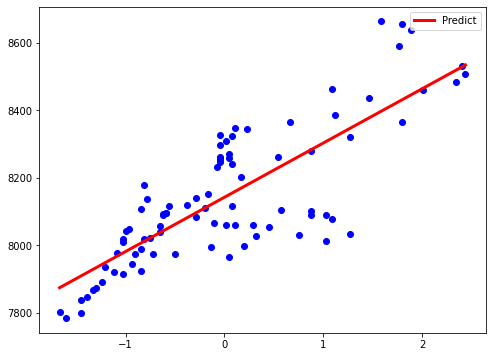

In [37]:
visualize(model, train_x, train_y)

In [38]:
# 예측
# transform을 하시는 분들은 실행해주세요
test_x = scaler.transform(test_x)
# y1_hat에 predict값 할당
pred_y = model.predict(test_x)

#성능평가
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

score(train_mse,test_mse)

Linear 198354.83081
 13.6354


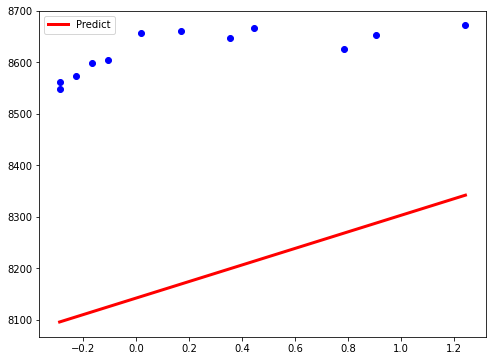

In [39]:
visualize(model, test_x, test_y)

loss가 작아졌는데 그림으로 보면 좀 별로이긴 하다.

두 개 가지고 standard scaler 한 번 더 써보기

In [40]:
train_x, train_y, test_x, test_y = load_data()

train_x = train_x[['Temp','Moisture']]
test_x = test_x[['Temp','Moisture']]

scaler = StandardScaler()
scaler = scaler.fit(train_x)
train_x = scaler.transform(train_x)

model = Ridge(random_state=123).fit(train_x, train_y)

esti_y = model.predict(train_x)

train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 3175.53036


In [41]:
test_x = scaler.transform(test_x)
# y1_hat에 predict값 할당
pred_y = model.predict(test_x)

test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 99324.58598


In [42]:
score(train_mse,test_mse)

 31.2781


변수 하나만 사용하는 것이 괜찮은 선택이라는 생각이 든다.

scaler 바꾸기 - minmaxscaler

In [43]:
train_x, train_y, test_x, test_y = load_data()

train_x = train_x[['Temp']]
test_x = test_x[['Temp']]

# 사용할 패키지를 import!
from sklearn.preprocessing import MinMaxScaler

In [44]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_x)
train_x = scaler.transform(train_x)
train_x.shape

(88, 1)

In [45]:
# 선형회귀 모델 생성 후 fitting 시킵니다.
model = Ridge(random_state=123).fit(train_x, train_y)

# 추정
esti_y = model.predict(train_x)

# Loss 및 시각화
train_mse = mse(esti_y, train_y)
print(f"Linear {train_mse:.5f}")

Linear 15226.30510


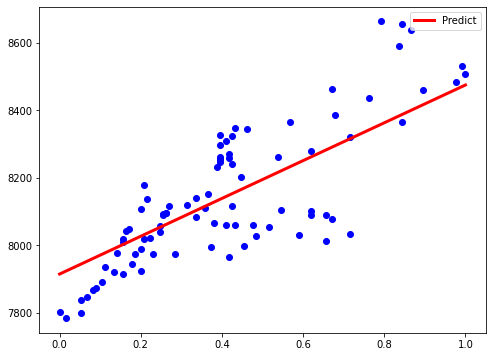

In [46]:
visualize(model, train_x, train_y)

In [47]:
# 예측
# transform을 하시는 분들은 실행해주세요
test_x = scaler.transform(test_x)
# y1_hat에 predict값 할당
pred_y = model.predict(test_x)

#성능평가
test_mse = mse(pred_y, test_y)
print(f"Linear {test_mse:.5f}")

Linear 202457.35936


In [48]:
score(train_mse,test_mse)

 13.2966


loss가 줄어들긴 했지만 큰 차이는 아닌 것으로 보인다.

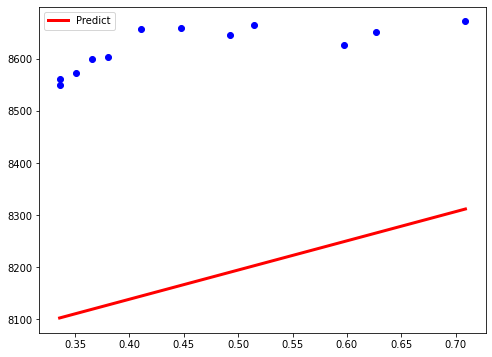

In [49]:
visualize(model, test_x, test_y)

이쯤되니 train_y와 test_y의 범위가 다른게 아닐까 생각이 들기도 한다

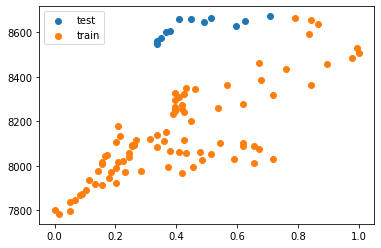

In [50]:
plt.scatter(test_x, test_y, label='test')
plt.scatter(train_x, train_y, label='train')
plt.legend()
plt.show()

그렇다......